# **Homework 1: COVID-19 Cases Prediction (Regression)**

Author: Heng-Jui Chang

Slides: https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.pdf  
Videos (Mandarin): https://cool.ntu.edu.tw/courses/4793/modules/items/172854  
https://cool.ntu.edu.tw/courses/4793/modules/items/172853  
Video (English): https://cool.ntu.edu.tw/courses/4793/modules/items/176529


Objectives:
* Solve a regression problem with deep neural networks (DNN).
* Understand basic DNN training tips.
* Get familiar with PyTorch.

If any questions, please contact the TAs via TA hours, NTU COOL, or email.


# **Download Data**


If the Google drive links are dead, you can download data from [kaggle](https://www.kaggle.com/c/ml2021spring-hw1/data), and upload data manually to the workspace.

In [127]:
tr_path = './DataSet/covid.train.csv'  # path to training data
tt_path = './DataSet/covid.test.csv'   # path to testing data

#!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
#!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

# **Import Some Packages**

In [128]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Sklearn
import sklearn
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import preprocessing

# Pandas
import pandas as pd


### Set seed

In [129]:
myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True  # with deterministic algorithms, You get the same outputs every time you train your model, Some operations may run slower, since PyTorch avoids faster but non-deterministic versions
torch.backends.cudnn.benchmark = False  #➡️ PyTorch will skip benchmarking and just use a safe, deterministic algorithm (usually IMPLICIT_GEMM or WINOGRAD_NONFUSED).✅ Reproducible results❌ Possibly slower than optimal
np.random.seed(myseed)  
torch.manual_seed(myseed)  # Sets the seed for CPU-based random operations in PyTorch.
if torch.cuda.is_available():  # If CUDA is available, set the seed for GPU-based random operations as well.
    torch.cuda.manual_seed_all(myseed)

device_count = torch.cuda.device_count()
print(f"Number of CUDA devices: {device_count}")

Number of CUDA devices: 1


# **Some Utilities**

You do not need to modify this part.

In [130]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

# learning curve and validation plot
def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])  # total training epochs
    x_1 = range(total_steps)  # ex: list(range(1000))
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:  # get predictions and targets from dataloader
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())  # detach from GPU and convert to CPU  # collect it batch by batch
                targets.append(y.detach().cpu()) 
        preds = torch.cat(preds, dim=0).numpy()   # list of tensors to a single tensor
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)   # alpha=0.5 makes the points semi-transparent. see overlapping points better
    plt.plot([-0.2, lim], [-0.2, lim], c='b')   # plot a line y=x, which is the ideal prediction line
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

#### Notes  
##### **1. preds.append(pred.detach().cpu())**  
we originally move the data to GPU 
This tensor:
- Is usually on the GPU (if x was on GPU)
- Is attached to the computation graph (so gradients can be calculated)  
we need to:
- Removes the tensor from the computation graph.
- This tells PyTorch: "I'm not going to backpropagate through this tensor."
- It's essential to avoid memory leaks or unnecessary gradient tracking during inference.  
* Moves the tensor from **GPU to CPU**, so you can safely:

  * Collect it in a list
  * Convert it to NumPy
  * Plot or save it  



##### **2. preds = torch.cat(preds, dim=0).numpy()**  
Now `preds` is a **list of tensors** — one tensor per batch. Example:

```python
preds = [Tensor(batch1), Tensor(batch2), Tensor(batch3)]
```

🧠 Why `torch.cat(preds, dim=0)`?

* Concatenates all batch tensors into a **single tensor**.
* `dim=0` (row) joins them along the batch axis (like stacking rows).

Example:

```python
# Suppose 3 batches of shape (2, 1)
preds = [tensor([[0.1], [0.2]]),
         tensor([[0.3], [0.4]]),
         tensor([[0.5], [0.6]])]

# After torch.cat(preds, dim=0)
tensor([[0.1],
        [0.2],
        [0.3],
        [0.4],
        [0.5],
        [0.6]])
```

🧠 Why `.numpy()`?

* Converts the final PyTorch tensor to a **NumPy array**.
* NumPy arrays are easier to:

  * Use in `matplotlib` plots
  * Save with `np.save()`
  * Compute with `sklearn` or other libraries

---

# **Feature Selection**



In [131]:
data = pd.read_csv(r'./DataSet/covid.train.csv')   
x = data[data.columns[1:94]]
y = data[data.columns[94]]

# Normalisation
x = (x - x.min()) / (x.max() - x.min())

# Create an instance of SelectKBest without specifying 'k'
bestfeatures = SelectKBest(score_func=f_regression)

# Compute the scores for all features
fit = bestfeatures.fit(x,y)

# Convert the scores into a DataFrame
dfscores = pd.DataFrame(fit.scores_)

# Create a DataFrame of the column names
dfcolumns = pd.DataFrame(x.columns)

# Concatenate the two DataFrames for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)

# Name the DataFrame columns
featureScores.columns = ['Specs','Score']  

# Print the 20 rows with the highest scores
print(featureScores.nlargest(20,'Score'))  

# Print the index of the most important features
top_rows = featureScores.nlargest(20, 'Score').index.tolist()[:17]
print(top_rows)

                 Specs          Score
75   tested_positive.1  148069.658278
57     tested_positive   69603.872591
42        hh_cmnty_cli    9235.492094
60      hh_cmnty_cli.1    9209.019558
78      hh_cmnty_cli.2    9097.375172
43      nohh_cmnty_cli    8395.421300
61    nohh_cmnty_cli.1    8343.255927
79    nohh_cmnty_cli.2    8208.176435
40                 cli    6388.906849
58               cli.1    6374.548000
76               cli.2    6250.008702
41                 ili    5998.922880
59               ili.1    5937.588576
77               ili.2    5796.947672
92  worried_finances.2     833.613191
74  worried_finances.1     811.916460
56    worried_finances     788.076931
87    public_transit.2     686.736539
69    public_transit.1     681.562902
51      public_transit     678.834789
[75, 57, 42, 60, 78, 43, 61, 79, 40, 58, 76, 41, 59, 77, 92, 74, 56]


### **1. data = pd.read_csv(r'covid.train.csv')**
By default, `pandas.read_csv()` assumes that **the first row is the header** (column names).
If your CSV file **does not have headers**, you should tell pandas:

```python
df = pd.read_csv('your_file.csv', header=None)
```
use r'...' to avoid \n new line...... “Interpret the string literally, don’t process backslashes.”

#### 🔁 Compare with:

| Path                 | Meaning                                   |
| -------------------- | ----------------------------------------- |
| `./file.csv`         | In the **current** folder                 |
| `../file.csv`        | In the **parent** folder                  |
| `/file.csv`          | In the **root** directory (on Unix/macOS) |
| `C:\folder\file.csv` | Absolute path on Windows                  |


#### Old way:

```python
data = pd.read_csv("file.csv")
x = data[data.columns[1:94]]
y = data[data.columns[94]]
```

✅ Keeps data in **DataFrame format**
✅ You can use **column names**, labels, and Pandas functionality
✅ Ideal for feature selection, visualization, etc.

---

#### New way:

```python
train_data = np.array(pd.read_csv("file.csv"))
```

✅ Converts directly to **NumPy array**
❌ **No access to column names**
✅ May be slightly faster and more memory-efficient
❌ You must use numeric indexing only (e.g. `train_data[:, 0:5]`)

---

### **2. Min-max scaling**

StandardScaler vs MinMax for Feature Selection?

| Scaler                       | Keeps Order | Keeps Relative Spacing  | Affects Variance                    | Good for f\_regression?                          |
| ---------------------------- | ----------- | ----------------------- | ----------------------------------- | ------------------------------------------------ |
| **MinMaxScaler**             | ✅ Yes       | ✅ Yes                   | ✅ Compresses all features to \[0,1] | ✅ Safe, common                                   |
| **StandardScaler (Z-score)** | ✅ Yes       | ❌ No (centers around 0) | ✅ Gives mean=0, std=1               | ✅ Also fine, slightly more sensitive to outliers |
| **No Scaling**               | ❌ No        | ❌ No                    | ❌ 


### **3. How to know which method to choose?**

✅ When to use `SelectKBest(f_regression)`:

| Use It When...                                    | Because                                           |
| ------------------------------------------------- | ------------------------------------------------- |
| Your **target variable is continuous**            | `f_regression` is for regression tasks            |
| You want a **fast, simple, interpretable** method | It’s efficient and easy to visualize              |
| You want a **baseline** for feature importance    | Good first step before using more complex methods |
| You're using a **linear model or neural network** | These are sensitive to irrelevant/noisy features  |
---
method to choose?
| Goal                                       | Recommended Feature Selector  | Notes                                   |
| ------------------------------------------ | ----------------------------- | --------------------------------------- |
| **Regression task** (target is continuous) | `f_regression`                | Fast and interpretable                  |
| **Classification task** (target is labels) | `chi2`, `mutual_info_classif` | Chi-squared needs non-negative features |
| Want nonlinear dependency detection        | `mutual_info_regression`      | Captures more complex patterns          |
| Want model-based selection                 | `Lasso`, `RandomForest`       | Slower but smarter (uses learning)      |
| Want recursive feature elimination         | `RFE`, `RFECV`                | Wraps around an estimator               |


# **Preprocess**

We have three kinds of datasets:
* `train`: for training
* `dev`: for validation
* `test`: for testing (w/o target value)

## **Dataset**

The `COVID19Dataset` below does:
* read `.csv` files
* extract features
* split `covid.train.csv` into train/dev sets
* normalize features

Finishing `TODO` below might make you pass medium baseline.

In [132]:
class COVID19Dataset(Dataset):   # input: path to csv file, mode (train/dev/test), target_only (if True, only load target features)
    '''step1: Dataset for loading and preprocessing the COVID19 dataset converts it to a PyTorch tensor of type float32.
   '''
    def __init__(self,
                 path,
                 mode='train',
                 target_only=False):
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:  # open the csv file, 'r' means read mode, fp is file pointer'
            data = list(csv.reader(fp))  # read the csv file into a list of lists (each row is a list)
                 # data: [['state', 'day1', 'day2', ..., 'day3', 'tested_positive'], ...]
                 # The first row is the header, so we skip it by slicing data[1:]
            data = np.array(data[1:])[:, 1:].astype(float)
        
        if not target_only:
            feats = list(range(93))  # All features (0-92)
        else:
            # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)
            #feats = list(range(40)) + [57, 75]  # Only state features and tested_positive features
            # feats = [i for i in range(40)] + [57, 75]  # Only state features and tested_positive features
            feats = [75, 57, 42, 60, 78, 43, 61, 79, 40, 58, 76, 41, 59, 77, 92, 74, 56] #上面挑选的最优特征
        

        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)  # mid output
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]
            
            # Splitting training data into train & dev sets  (quick and reproducible way without using sklearn)
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]
            # If your data is ordered (e.g., time-series), this split may introduce bias, need to shuffle the data before splitting.


            # Convert data into PyTorch tensors 
            self.data = torch.FloatTensor(data[indices])   # mid output # dimension change numpy array to PyTorch tensor
            self.target = torch.FloatTensor(target[indices])  # mid output

        # Normalize features (you may remove this part to see what will happen)
        self.data[:, 40:] = \
            (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
            / self.data[:, 40:].std(dim=0, keepdim=True)  # Z-score standardization (Standardizes each feature to mean 0, std 1)  # keepdim=True keeps the dimensions of the tensor, so the mean and std are broadcasted correctly across the features. make sure the dimensions match when performing operations like subtraction and division.

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))
    '''step2: get a sample at an index'''
    def __getitem__(self, index):
        # Returns individual sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]         # It allows PyTorch to access individual samples from your dataset when training or evaluating a model. The idx parameter is the index of the sample you want to access.
        
    '''step3: number of rows in the dataset'''
    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)      # # Returns the number of samples in the dataset. This is needed by PyTorch to know the dataset size.

### init Getilem len 3 step
### **1. torchvision.datasets.ImageFolder**

You can use `torchvision.datasets.ImageFolder` when your image data is organized in directories where each subdirectory represents a class, and all images in that subdirectory belong to that class.

In your ConcreteDataset, you manually convert a NumPy array to PyTorch tensors and implement the __getitem__ and __len__ methods because you are building a custom dataset from scratch (not using any built-in dataset class).  **need of the three steps**

**When to use:**
- When you have a folder structure like:
  ```
  root/
    class1/
      img1.jpg
      img2.jpg
      ...
    class2/
      img3.jpg
      img4.jpg
      ...
    ...
  ```
- When you want to quickly load images and their labels for classification tasks.

**What kind of data:**
- Image classification datasets (multi-class or binary).
- Each class has its own folder.
- Supported image formats (e.g., .jpg, .png).

**Example usage in your workspace:**  
See HW4 copy.ipynb, where `datasets.ImageFolder` is used to load the `animals/train` and `animals/val` folders for multi-class classification (cats, dogs, pandas).

### **2. self.data = torch.FloatTensor(data[indices])**
Certainly! Here’s a concrete example for the line:

```python
self.data = torch.FloatTensor(data[indices])
```

Suppose your **original NumPy array** `data` looks like this (with 5 samples and 3 features):

```python
import numpy as np

data = np.array([
    [1.0, 2.0, 3.0],   # sample 0
    [4.0, 5.0, 6.0],   # sample 1
    [7.0, 8.0, 9.0],   # sample 2
    [10.0, 11.0, 12.0],# sample 3
    [13.0, 14.0, 15.0] # sample 4
])  # shape: (5, 3)
```

Suppose `indices = [0, 2, 4]` (selecting samples 0, 2, and 4):

```python
selected = data[indices]
# selected =
# array([[ 1.,  2.,  3.],
#        [ 7.,  8.,  9.],
#        [13., 14., 15.]])
# shape: (3, 3)
```

Now, convert to a PyTorch tensor:

```python
import torch
tensor_data = torch.FloatTensor(selected)
# tensor_data =
# tensor([[ 1.,  2.,  3.],
#         [ 7.,  8.,  9.],
#         [13., 14., 15.]])
# shape: torch.Size([3, 3])
```

**Summary Table:**

| Step                | Type         | Shape    | Example Values                |
|---------------------|--------------|----------|------------------------------|
| Original `data`     | np.ndarray   | (5, 3)   | see above                    |
| `data[indices]`     | np.ndarray   | (3, 3)   | rows 0, 2, 4                 |
| `torch.FloatTensor` | torch.Tensor | (3, 3)   | same values, type float32    |

This is exactly what happens in your code for each split (train/dev/test), just with more samples and features.

## **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.


In [133]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,  # mode is 'train', true, shuffle the data
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

#### **1. drop last: 
##### If `drop_last=True`:
* **Drops** the last smaller batch.
* Using the same example, you get:

  * One batch of 64
  * **No batch of 36** — it's dropped


##### 📌 Why use `drop_last=True`?

##### ✅ Common reasons:

1. **For training**: It’s sometimes helpful to ensure all batches are the **same size** (e.g., for batch norm).
2. **Avoid irregular shapes** in models that require fixed input sizes.
3. In **multi-GPU training**, each GPU must receive the same batch size.

---

##### ⚠️ When NOT to use `drop_last=True`:

* When you **want to use all data**, especially if your dataset is small.
* During **evaluation/testing**, where accuracy matters more than batch consistency.



# **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.


In [134]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.BatchNorm1d(16), #accelerates training by normalizing the inputs to each layer, which can help with convergence and stability.
            nn.Dropout(p=0.2), # Dropout is a regularization technique that helps prevent overfitting by randomly setting a fraction of the input units to zero during training.
            nn.ReLU(),
            #nn.Linear(64, 32),
            #nn.ReLU(),
            nn.Linear(16, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')  # reduction='mean' means the loss is averaged over all elements in the batch. This is useful for regression tasks where you want to minimize the average error across all predictions. If you want to sum the losses instead, you can use reduction='sum'. If you want to return the loss for each element in the batch, you can use reduction='none'.

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)  # (3. more explain) Squeeze removes the dimension of size 1 from the output tensor, which is useful when you want to convert a tensor of shape (batch_size, 1) to (batch_size,). This is often done in regression tasks where the output is a single value for each input sample.

    def cal_loss(self, pred, target):
        ''' Calculate loss # TODO: you may implement L1/L2 regularization here'''
        regularization_loss = 0
        for param in self.parameters():
            regularization_loss += torch.sum(param ** 2) # L2 regularization
        return self.criterion(pred, target) + 0.00075 * regularization_loss

Behind the scenes, this:

```python
model(x)
```

**automatically calls**:

```python
model.__call__(x)
→ self.forward(x)
```


### **1. What is L2 Regularization?**

**L2 regularization**, also known as **weight decay**, is a technique used to **reduce overfitting** in machine learning models by penalizing large weight values.

🧠 Formal Definition:

For a model with weights $w$, the total loss becomes:

$$
\text{Total Loss} = \text{Original Loss} + \lambda \sum_{i} w_i^2
$$

Where:

* $\lambda$ is the **regularization strength** (a small constant like `0.00075`)
* $\sum w_i^2$ is the **sum of squares of all weights**
* The regularization term discourages the model from making any weight too large

✅ In PyTorch Code:

```python
for param in model.parameters():
    regularization_loss += torch.sum(param ** 2)

loss = criterion(pred, target) + λ * regularization_loss
```

---
📌 Why use L2 regularization?

| Reason                                   | Benefit                           |
| ---------------------------------------- | --------------------------------- |
| Prevents weights from becoming too large | Reduces model complexity          |
| Helps avoid overfitting                  | Generalizes better to unseen data |
| Keeps learning smooth                    | Encourages simpler solutions      |
| Works well with gradient descent         | Differentiable and efficient      |

---

🔍 L1 vs. L2 Regularization (Quick Comparison)

| Feature     | **L1**                      | **L2**                        |   |                      |
| ----------- | --------------------------- | ----------------------------- | - | -------------------- |
| Formula     | ( \lambda \sum              | w\_i                          | ) | $\lambda \sum w_i^2$ |
| Effect      | Sparsity (many weights = 0) | Shrinks all weights slightly  |   |                      |
| Use case    | Feature selection           | Smooth, stable regularization |   |                      |
| Also called | Lasso                       | Ridge                         |   |                      |


Great question — let’s break it down clearly so you understand **why L2 regularization causes weight decay** and how it helps your model.

---

### **2. 💡 What Is Weight Decay?**

**Weight decay** is just another name for **L2 regularization**.

The idea is:

> Penalize large weights in your model by adding a small cost to the loss function for big weight values.

This helps prevent **overfitting** and encourages the model to keep weights small and general.

---

 📉 How Does L2 Regularization Work?

In L2 regularization, the **loss function** becomes:

$$
\text{Total Loss} = \text{Original Loss} + \lambda \sum_{i} w_i^2
$$

Where:

* `Original Loss` = e.g. MSE or Cross Entropy
* `w_i` = each trainable weight
* `λ` (lambda) = regularization strength (e.g. `0.00075`)

---

🔁 How It Causes Weight Decay

During backpropagation, the optimizer updates the weights like this:

$$
w \leftarrow w - \text{lr} \cdot \left( \frac{\partial \text{Loss}}{\partial w} + \lambda \cdot w \right)
$$

The extra term `+ λ·w` pulls the weight toward **zero**.

- This is why it’s called **weight decay**:

> Each weight shrinks a little every step → "decaying" over time.

---
🤔 Why Add Weight Decay?
🎯 Purpose:

* **Reduce overfitting** on training data
* **Improve generalization** to unseen data
* Keep the model **simpler** by preventing very large weight values

---

✅ Optimizer vs. Manual

You have two ways to apply weight decay (L2):
1. 🔧 Automatically with Optimizer

```python
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00075)
```

PyTorch will apply L2 during gradient updates.

---

**✍️ Manually in Loss Function**

```python
loss = criterion(pred, target) + lambda * sum(param**2 for param in model.parameters())
```

But don’t **do both** — you’ll apply L2 **twice**!

---


### **3. self.net(x).squeeze(1)**
The code in question is:
```python
self.net(x).squeeze(1)
```
This is from the `forward` method of your `NeuralNet` class.

---

#### What does it do?

- `self.net(x)` passes the input tensor `x` through the neural network (`self.net`), producing an output tensor.
- The output shape from the last layer is typically `(batch_size, 1)` (since you have `nn.Linear(..., 1)` as the last layer).
- `.squeeze(1)` removes the dimension at index 1 **if it is size 1**.

---

#### What is the original size?

- **Input:** `x` is usually of shape `(batch_size, input_dim)`.
- **Output before squeeze:** After `self.net(x)`, the shape is `(batch_size, 1)`.

---

#### What is the result?

- **After `.squeeze(1)`:** The shape becomes `(batch_size,)` (a 1D tensor with one value per sample in the batch).

---

**Summary Table:**

| Step                | Shape                  |
|---------------------|------------------------|
| Input `x`           | `(batch_size, input_dim)` |
| After `self.net(x)` | `(batch_size, 1)`         |
| After `.squeeze(1)` | `(batch_size,)`           |

This is commonly done for regression tasks, so the output matches the target shape.

# **Train/Dev/Test**

## **Training**

In [135]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])  # **dict	Unpack dictionary into keyword arguments

    min_mse = 1000.  # or min_mse = float('inf')  # Initialize minimum MSE to a large value
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader (x is a batch of input features, y is a batch of target values)
            optimizer.zero_grad()               # set gradient to zero (weights update one time in every batch, so we need to zero the gradients before each batch)
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())  # 1 loss value per batch

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device) # the average loss of 1 epoch (unit is a sample)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0  # Reset early stop counter if model improved
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

### **Important note**
Your original code records the loss **with weight decay included** (i.e., MSE loss + L2 penalty) because:

- **The total loss (MSE + L2 penalty) is what the model actually optimizes during training.**
- Recording this "full" loss gives you a true picture of what the optimizer is minimizing.
- If you only record the MSE loss, your learning curve might look better than the real optimization objective, and you might not notice if the regularization term is dominating or affecting convergence.

**In summary:**  
Recording the total loss (including weight decay) helps you monitor the real objective being minimized, making your training/validation curves more honest and comparable to the actual optimization process. This is especially important when tuning the regularization strength, as it lets you see its effect on the total loss.

### **1. under the scene of each batch**
#### 🔁 Full Update Cycle in Each Batch:

In every **training batch**, this is what happens:

```python
# 1. Forward pass
pred = model(x_batch)

# 2. Loss computation
loss = model.cal_loss(pred, y_batch)

# 3. Backward pass: compute gradients
loss.backward()

# 4. Update weights using gradients
optimizer.step()

# 5. Clear accumulated gradients for the next batch
optimizer.zero_grad()
```
#### 1. `.backward()`

Fills:

```python
model.weight.grad  → ∂loss/∂weight  (shape [1, 5])
model.bias.grad    → ∂loss/∂bias    (shape [1])
```

---

#### 2. `optimizer.step()`

Does this for each parameter:

```python
# Example for SGD
for param in model.parameters():
    param.data -= lr * param.grad
```

In our earlier example:

If:

```python
param.grad = tensor([0.5, -0.2, 0.1, 0.0, -0.3])
param.data = tensor([0.0, 0.0, 0.0, 0.0, 0.0])
```

Then after `optimizer.step()` with `lr = 0.1`:

```python
param.data = tensor([-0.05, 0.02, -0.01, 0.0, 0.03])
```

Each parameter moves a little **in the direction that reduces the loss**.

---

#### 🚨 Important: No `.step()` Without `.backward()`

If you skip `.backward()` or forget `loss.backward()`, then `.grad` will be `None`, and `.step()` does nothing.

---

#### 🧹 Don’t Forget `.zero_grad()`

Always clear gradients **before the next batch**, or they will accumulate:

```python
optimizer.zero_grad()
```

This resets all `param.grad` to 0.


---
#### **🔁 Main Training Loop — Math Under the Hood**

We’ll walk through:

1. Forward pass
2. Loss calculation (MSE + L2 regularization)
3. Backward pass
4. Parameter update
5. Repeat for each batch

---

##### **1. Forward Pass**

For a batch of input data $\mathbf{X} \in \mathbb{R}^{N \times d}$ (where $N$ is the batch size, and $d$ is the input dimension), the network computes:

$$
\hat{\mathbf{y}} = f(\mathbf{X}; \boldsymbol{\theta})
$$

For your model with two layers:

$$
\begin{aligned}
\mathbf{h}_1 &= \text{ReLU}(\text{Dropout}(\text{BatchNorm}(\mathbf{X} \mathbf{W}_1 + \mathbf{b}_1))) \\
\hat{\mathbf{y}} &= \mathbf{h}_1 \mathbf{W}_2 + \mathbf{b}_2
\end{aligned}
$$

Where:

* $\mathbf{W}_1, \mathbf{b}_1$: weights and bias of the first layer
* $\mathbf{W}_2, \mathbf{b}_2$: weights and bias of the second layer
* $\boldsymbol{\theta}$: all trainable parameters

---

##### **2. Loss Calculation (with L2 Regularization)**

 **a. Mean Squared Error (MSE) Loss**:

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (\hat{y}_i - y_i)^2
$$

Where:

* $\hat{y}_i$ is the prediction
* $y_i$ is the ground truth

 **b. L2 Regularization Term**:

$$
\text{L2 penalty} = \lambda \sum_{j} \theta_j^2
$$

Where:

* $\lambda$: regularization strength
* $\theta_j$: each trainable weight (biases often excluded)

 **c. Total Loss**:

$$
\text{Total Loss} = \text{MSE} + \lambda \sum_j \theta_j^2
$$

---

##### **3. Backward Pass**

PyTorch computes the gradient of the total loss with respect to each parameter:

$$
\frac{\partial \text{Total Loss}}{\partial \theta_j} = \frac{\partial \text{MSE}}{\partial \theta_j} + 2 \lambda \theta_j
$$

---

##### **4. Parameter Update**

If using **SGD**, the update rule is:

$$
\theta_j \leftarrow \theta_j - \eta \cdot \frac{\partial \text{Total Loss}}{\partial \theta_j}
$$

If using **SGD with momentum**:

$$
\begin{aligned}
v_j &\leftarrow \mu v_j + \eta \cdot \frac{\partial \text{Total Loss}}{\partial \theta_j} \\
\theta_j &\leftarrow \theta_j - v_j
\end{aligned}
$$

Where:

* $\eta$: learning rate
* $\mu$: momentum factor
* $v_j$: velocity term (momentum accumulator)

---

##### **5. Repeat for Each Batch and Epoch**

This full loop repeats for every mini-batch in every epoch.

---

#### ✅ Summary Table

| Step           | Formula                                                              |
| -------------- | -------------------------------------------------------------------- |
| **Forward**    | $\hat{y} = f(\mathbf{X}; \boldsymbol{\theta})$                       |
| **MSE Loss**   | $\frac{1}{N} \sum_{i=1}^N (\hat{y}_i - y_i)^2$                       |
| **L2 Penalty** | $\lambda \sum_j \theta_j^2$                                          |
| **Total Loss** | $\text{MSE} + \lambda \sum_j \theta_j^2$                             |
| **Gradient**   | $\frac{\partial \text{MSE}}{\partial \theta_j} + 2 \lambda \theta_j$ |
| **Update**     | $\theta_j \leftarrow \theta_j - \eta \cdot \text{gradient}$          |

---
### **2. Why use `.detach().cpu().item()`**
Because:

* You **don’t want to track** the loss in autograd anymore
* You want to **move it to CPU** (safe for logging)
* You want it as a **float**, not a tensor

### **3. Early stopping count**
The **typical value for early stopping count (also called “patience”)** depends on your model, dataset, and how noisy your validation loss is — but here's a general guideline:

---

#### ✅ Common Ranges:

| Scenario                               | Suggested `early_stop` Count |
| -------------------------------------- | ---------------------------- |
| Small model / low noise                | **3 to 5**                   |
| Medium-sized / moderate noise          | **5 to 10**                  |
| Large / deep models (e.g. CNNs, LSTMs) | **10 to 20+**                |

---

#### 📌 Key Considerations:

1. **Noise in validation loss:**

   * If your `dev_mse` fluctuates a lot (due to randomness in batches, dropout, etc.), use **larger patience** to avoid stopping too early.

2. **Epoch duration:**

   * If one epoch is **slow to run**, you may prefer a smaller patience to save compute time.
   * If one epoch is **fast**, a longer patience is acceptable.

3. **Overfitting behavior:**

   * If your model starts to overfit quickly, use **shorter patience** (e.g., 3–5).
   * If your model takes a while to learn useful patterns, use **longer patience** (e.g., 10–15).

4. **Learning rate schedule:**

   * If you're using learning rate decay, early stopping patience should often be **longer than the decay step interval** so it has time to adapt.

---

#### 🧠 Good Default for Most DNNs:

```python
early_stop = 5
```

This allows 5 chances (epochs) to improve — a balance between stopping too early and wasting time.

---

#### 🧪 Optional Tip:

Many frameworks (like `keras.callbacks.EarlyStopping`) even allow:

```python
restore_best_weights=True
```

which reloads the model weights from the **best** epoch when stopping occurs.

---



## **Validation**

In [136]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss for sum of 1 batch # sample is the unit
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss　（divide by total samples in the dataset)

    return total_loss  # averaged loss of 1 epoch(unit is a sample)

## **Testing**

In [137]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output) # tensor of predictions for one batch: tensor([12.5,  8.3, 15.7,  9.1])
            preds.append(pred.detach().cpu())   # collect prediction  # (after append) is a list of batch tensors.
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds # came from 1 epoch, multiple batches, so it is a list of tensors, each tensor is a batch of predictions. After concatenation, it becomes a single numpy array of predictions for all samples in the test set.

### **1. Example change**

```python
pred = model(x)                     # forward pass (compute output)
preds.append(pred.detach().cpu())   # collect prediction
preds = torch.cat(preds, dim=0).numpy()
```
#### 1. `pred = model(x)`

Suppose your batch size is 4. The model outputs a tensor (on GPU):

````python
# pred (on GPU)
tensor([12.5,  8.3, 15.7,  9.1], device='cuda:0', grad_fn=<SqueezeBackward1>)
````

#### 2. `preds.append(pred.detach().cpu())`

- `.detach()` removes gradient tracking.
- `.cpu()` moves tensor to CPU. **NumPy arrays can only operate on CPU memory**

After this, `preds` is a list of tensors (one per batch):

````python
# After first batch
preds = [tensor([12.5,  8.3, 15.7,  9.1])]  # on CPU, no grad

# After more batches, e.g. 3 batches:
preds = [
    tensor([12.5,  8.3, 15.7,  9.1]),
    tensor([10.2, 11.3,  7.8, 13.4]),
    tensor([ 9.9, 14.2,  8.7, 12.1])
]
````

#### 3. `preds = torch.cat(preds, dim=0).numpy()`

- `torch.cat(preds, dim=0)` stacks all batch tensors into one tensor: Concatenates the list of tensors along the batch dimension (dim=0), like stacking rows into one tensor
````python
tensor([12.5,  8.3, 15.7,  9.1, 10.2, 11.3,  7.8, 13.4,  9.9, 14.2,  8.7, 12.1])
````

- `.numpy()` converts it to a NumPy array:
````python
array([12.5,  8.3, 15.7,  9.1, 10.2, 11.3,  7.8, 13.4,  9.9, 14.2,  8.7, 12.1])
````

**Summary Table:**

| Step                                 | Example Output (shape)                        |
|-------------------------------------- |-----------------------------------------------|
| `pred = model(x)`                     | tensor([12.5, 8.3, 15.7, 9.1]) (4,)           |
| `preds.append(pred.detach().cpu())`   | [tensor([12.5, ...]), ...] (list of (4,))     |
| `torch.cat(preds, dim=0).numpy()`     | array([12.5, 8.3, ..., 12.1]) (N,)            |

**Result:**  
You get a 1D NumPy array of all predictions for the dataset, one value per sample.

# **Setup Hyper-parameters**

`config` contains hyper-parameters for training and the path to save your model.

In [138]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = True                   # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 10000,                # maximum number of epochs #3000 using ealy stop so large number is fine 
    'batch_size': 200,               # mini-batch size for dataloader  #270
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim) #SGD
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.0005,                 # learning rate of SGD #0.001
        #'momentum': 0.9              # momentum for SGD #0.9
    },
    'early_stop': 1000,               # early stopping epochs (the number epochs since your model's last improvement)  #200
    'save_path': 'models/model.pth'  # your model will be saved here
}

### **1. How to tune**  
Here’s a practical guide for tuning and setting the hyper-parameters in your `config` dictionary, based on your dataset and typical deep learning practice:

---

#### 1. `n_epochs` (Maximum number of epochs)
- **What it does:** Maximum times the model will see the whole training set.
- **How to set:**  
  - If you use early stopping, you can set this high (e.g., 300–3000).
  - If your model overfits quickly, use a lower value.
- **Tip:** Early stopping will usually stop before reaching this number.

---

#### 2. `batch_size`
- **What it does:** Number of samples per gradient update.
- **How to set:**  
  - **Small dataset:** Use a larger batch size (e.g., 64, 128, 256, 512).
  - **Large dataset:** Use what fits in your GPU memory (commonly 32–256).
  - **Rule of thumb:** Try 64 or 128 first. If you have memory issues, reduce it.
- **Effect:** Larger batch = faster but less frequent updates; smaller batch = more updates, possibly better generalization.

---

#### 3. `optimizer`
- **What it does:** Optimization algorithm.
- **How to set:**  
  - For most DNNs, **Adam** is a good default (`'Adam'`).
  - For simple models or if you want to experiment, try `'SGD'` with momentum.
- **Tip:** Adam usually converges faster and is less sensitive to learning rate.

---

#### 4. `optim_hparas` (Learning rate, momentum, etc.)
- **`lr` (learning rate):**
  - **Adam:** Start with `0.001` or `0.0005`.
  - **SGD:** Start with `0.01` or `0.1` (but you may need to tune down).
- **`momentum`:**
  - Only for SGD. Try `0.9` as a default.
- **Tip:** If loss does not decrease, lower the learning rate.

---

#### 5. `early_stop`
- **What it does:** Number of epochs to wait for improvement before stopping.
- **How to set:**  
  - If your validation loss is noisy, use a higher value (e.g., 10–20).
  - If your model overfits quickly, use a lower value (e.g., 5).
  - **Default:** 10 is a good starting point.
- **Tip:** Too high = waste time; too low = might stop too early.

---

#### 6. `save_path`
- **What it does:** Where to save your best model.
- **How to set:**  
  - Any valid path, e.g., `'models/model.pth'`.

---

#### Example for your dataset

```python
config = {
    'n_epochs': 1000,                # Try 1000, early stopping will likely stop earlier
    'batch_size': 128,               # Try 128 or 256 if your GPU can handle it
    'optimizer': 'Adam',             # Adam is a good default
    'optim_hparas': {
        'lr': 0.001,                 # Adam default
        # 'momentum': 0.9            # Only needed for SGD
    },
    'early_stop': 10,                # Stop if no improvement for 10 epochs
    'save_path': 'models/model.pth'
}
```

---

#### **How to Tune**
1. **Start with defaults above.**
2. **Train and watch the learning curve.**
3. **If loss plateaus too early:**  
   - Lower the learning rate.
   - Increase `early_stop`.
4. **If overfitting:**  
   - Lower `n_epochs` or `early_stop`.
   - Add more regularization (e.g., increase dropout or L2 penalty).
5. **If training is slow:**  
   - Increase `batch_size` (if memory allows).
6. **If validation loss is noisy:**  
   - Increase `early_stop`.

---

**Summary Table:**

| Hyper-parameter | Typical Value      | How to Tune                        |
|-----------------|-------------------|-------------------------------------|
| n_epochs        | 300–3000          | Use early stopping                  |
| batch_size      | 64, 128, 256      | As large as fits in GPU             |
| optimizer       | 'Adam' or 'SGD'   | Adam is usually better              |
| lr (Adam)       | 0.001, 0.0005     | Lower if loss is unstable           |
| lr (SGD)        | 0.01, 0.1         | Lower if loss is unstable           |
| momentum        | 0.9               | Only for SGD                        |
| early_stop      | 5–20              | Higher if validation loss is noisy  |

---

**Tip:**  
Always monitor both training and validation loss. Adjust hyper-parameters based on their trends. Try only changing one parameter at a time for clear results.

# **Load data and model**

In [139]:
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 17)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 17)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 17)


C:\Users\USER\AppData\Local\Temp\ipykernel_25908\4152759328.py:52: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  / self.data[:, 40:].std(dim=0, keepdim=True)  # Z-score standardization (Standardizes each feature to mean 0, std 1)  # keepdim=True keeps the dimensions of the tensor, so the mean and std are broadcasted correctly across the features. make sure the dimensions match when performing operations like subtraction and division.


In [140]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

### **1. .dataset.dim**
Since tr_set has a Dataloader and a COVID19Dataset(Dataset) class  it calls the attribute in Dataloader to get the raw data
In PyTorch’s source code for `DataLoader`:

```python
class DataLoader:
    def __init__(self, dataset, ...):
        self.dataset = dataset
```

That’s it — `.dataset` is just an attribute set during initialization. It points back to your original `COVID19Dataset` object.


calls the attribute of COVID19Dataset(Dataset) class to get the dimension:
From your original code:

```python
self.dim = self.data.shape[1]
```

This line sets the `.dim` attribute to the **number of features (columns)** in your dataset — i.e., the second dimension of the data matrix.

🧠 Recap: What kind of attribute is `.dim`?

| Attribute | Kind                      | Where it's from                    | Description                         |
| --------- | ------------------------- | ---------------------------------- | ----------------------------------- |
| `dim`     | Custom instance attribute | Defined in your class’s `__init__` | Stores the number of input features |

<br>

---


<br>

### **2. When to move to device (GPU) and move back to CPU**
Excellent question — managing **`device` movement** (i.e., moving tensors and models between CPU and GPU) is **crucial** for efficient and correct training in PyTorch. Let's break it down clearly:


#### ✅ General Rule of Device Usage in PyTorch

##### 1. **Model to device first**

```python
model = MyModel()
model.to(device)  # Move model parameters to GPU or CPU
```

* Do this **before training begins**, usually right after model creation.


##### 2. **Data to device inside the training loop**

```python
for x_batch, y_batch in train_loader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    ...
```

* You move **each mini-batch** to the device **right before the forward pass**.
* Don't move the entire dataset to GPU at once — it consumes too much memory.


##### 3. **Tensors from model output will also be on the same device**

```python
output = model(x_batch)  # output is on the same device as model and input
```


##### 4. **Move data back to CPU only when needed**

You typically move tensors **back to CPU** when:

* Saving results to disk
* Converting tensors to NumPy arrays for analysis or plotting
* Logging or debugging outside GPU

```python
output_cpu = output.detach().cpu().numpy()
```

> ✅ `detach()` removes the computation graph
> ✅ `cpu()` moves from GPU to CPU
> ✅ `numpy()` converts to NumPy


##### 🔁 **Full Training Loop Example with Device Handling**

```python
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MyModel()
model.to(device)  # Step 1: move model to device

for epoch in range(num_epochs):
    for x_batch, y_batch in train_loader:
        # Step 2: move data to device
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        output = model(x_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()

        # Step 3: move output back to CPU if needed
        preds = output.detach().cpu().numpy()  # for metrics/logging
```


#### 🧠 Summary Table

| Step | What to move                    | When                       | Why                                |
| ---- | ------------------------------- | -------------------------- | ---------------------------------- |
| 1    | `model.to(device)`              | Once before training       | So computations happen on GPU      |
| 2    | `x.to(device)` / `y.to(device)` | Every batch                | Ensure data matches model's device |
| 3    | `output.detach().cpu()`         | When saving/logging/output | To free GPU and use NumPy          |


# **Start Training!**

In [141]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 314.1988)
Saving model (epoch =    2, loss = 305.5474)
Saving model (epoch =    3, loss = 303.0509)
Saving model (epoch =    4, loss = 299.9303)
Saving model (epoch =    8, loss = 298.4562)
Saving model (epoch =   10, loss = 296.1494)
Saving model (epoch =   11, loss = 292.2163)
Saving model (epoch =   12, loss = 290.4170)
Saving model (epoch =   13, loss = 288.5070)
Saving model (epoch =   14, loss = 282.3583)
Saving model (epoch =   15, loss = 279.4553)
Saving model (epoch =   16, loss = 276.8430)
Saving model (epoch =   17, loss = 275.1930)
Saving model (epoch =   18, loss = 269.1803)
Saving model (epoch =   19, loss = 268.0863)
Saving model (epoch =   20, loss = 265.3432)
Saving model (epoch =   21, loss = 257.0929)
Saving model (epoch =   23, loss = 256.1613)
Saving model (epoch =   24, loss = 250.2685)
Saving model (epoch =   25, loss = 243.0853)
Saving model (epoch =   28, loss = 237.3011)
Saving model (epoch =   29, loss = 234.8892)
Saving mod

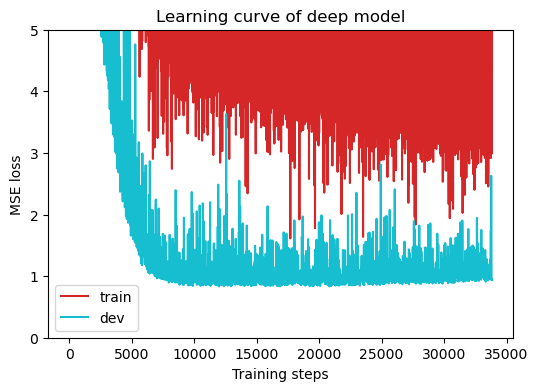

In [142]:
plot_learning_curve(model_loss_record, title='deep model')

C:\Users\USER\AppData\Local\Temp\ipykernel_25908\1425700501.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(config['save_path'], map_location='cpu')  #

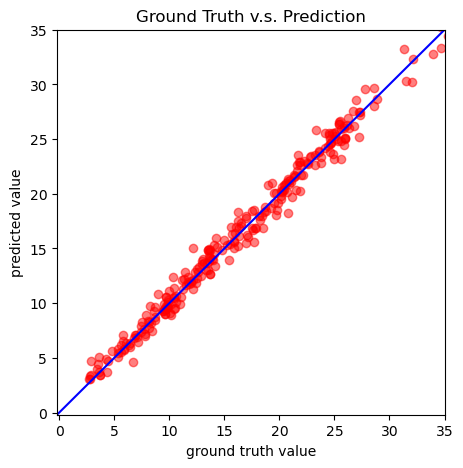

In [143]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

### **1. del model**
#### ✅ Why delete it?

* To **clear GPU/CPU memory**, especially if training is done.
* To ensure a **clean reload** from the saved checkpoint — so you're only using the best weights saved to disk.

---

#### ✅ Then you create a **new model object**:

```python
model = NeuralNet(...).to(device)
```

This new object is:

* Structurally identical
* Clean (random weights at this point)
* Ready to be **filled with trained weights** using:

```python
model.load_state_dict(torch.load(...))
```

---
### **2. map_location = 'cpu'**
Excellent! Let's clearly **separate the purposes** of:

1. ✅ Using `map_location='cpu'` when loading a model
2. ✅ Using `.to('cpu')` to move a model or tensor to the CPU

---

🧩 1. **Purpose of `map_location='cpu'` in `torch.load()`**

#### 🎯 Main Purpose:

To **safely load a checkpoint** that might have been saved on GPU, even if you’re currently **not using GPU**.

#### ✅ Use case:

* The saved file contains CUDA tensors (e.g., saved with `.to('cuda')`)
* You’re loading it **on a CPU-only machine**
* You want to **prevent deserialization errors**

#### 🔒 Example:

```python
ckpt = torch.load('model.pth', map_location='cpu')  # safely load CUDA checkpoint to CPU
```

#### ✅ Summary:

| Goal                          | `map_location='cpu'`        |
| ----------------------------- | --------------------------- |
| Load checkpoint to CPU        | ✅ Yes                       |
| Prevent device mismatch error | ✅ Yes                       |
| Needed when loading on CPU    | ✅ Yes                       |
| Moves model or tensor?        | ❌ No (only affects loading) |

---

🧩 2. **Purpose of `.to('cpu')` (or `.to(device)`)**

#### 🎯 Main Purpose:

To **move an already existing model or tensor** to a specific device (CPU or GPU) — after it’s been created or loaded.

#### ✅ Use case:

* You finished loading model weights
* Now you want to move the model to CPU (or GPU) for use
* You’re doing **inference**, **evaluation**, or **training**

### 🔄 Example:

```python
model = model.to('cpu')  # move model to CPU
```

Or:

```python
x = x.to(device)  # move tensor to CPU or GPU
```

#### ✅ Summary:

| Goal                         | `.to('cpu')` or `.to(device)` |
| ---------------------------- | ----------------------------- |
| Move model/tensor to CPU     | ✅ Yes                         |
| Needed for inference or eval | ✅ Often                       |
| Changes storage location?    | ✅ Yes                         |
| Needed before forward pass   | ✅ Yes                         |

---

#### ✅ Side-by-Side Comparison

| Feature                        | `map_location='cpu'`                     | `.to('cpu')`                         |
| ------------------------------ | ---------------------------------------- | ------------------------------------ |
| Part of                        | `torch.load()`                           | `.to()` method                       |
| Applies to                     | **File loading**                         | **Model or tensor objects**          |
| Purpose                        | Load tensors to CPU regardless of origin | Move object to CPU (or other device) |
| Prevents CUDA load errors      | ✅ Yes                                    | ❌ No (not related to loading)        |
| Required for CPU-only machines | ✅ Yes                                    | ✅ Yes (if using CPU)                 |
| Moves live object              | ❌ No                                     | ✅ Yes                                |

---



# **Testing**
The predictions of your model on testing set will be stored at `pred.csv`.

In [144]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv


### **1. alternative: pandas to save file**

Rewritten with `pandas`:

```python
import pandas as pd

def save_pred(preds, file):
    ''' Save predictions to specified file using pandas '''
    print('Saving results to {}'.format(file))
    df = pd.DataFrame({
        'id': range(len(preds)),
        'tested_positive': preds
    })
    df.to_csv(file, index=False)


preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')
```


### Output CSV:

```
id,tested_positive
0,4.318
1,3.215
2,2.792
...
```



## retrospective analysis
## **1.** :
originally I was using  
### **L2 regulization (not the problem)** 
#### ✅**What L2 does:**

L2 adds a penalty to the loss function, proportional to the square of the weights:

$$
\text{Loss}_{\text{total}} = \text{Loss}_{\text{MSE}} + \lambda \sum w^2
$$

So even if your model fits the data well (low MSE), the **L2 penalty** increases the total training loss.

---

#### ✅ Why It's Beneficial

* **Discourages large weights**, which makes the model **simpler and more generalizable**.
* Helps **prevent overfitting**, just like Dropout or data augmentation.
* Adds a kind of **“soft constraint”** on the model capacity, which acts like **a form of noise** during training because the model has to trade off between fitting and staying small.

#### 🔎 Validation Loss Often Looks Lower

During **validation**, the L2 term is **not included**, so:

$$
\text{Loss}_{\text{val}} = \text{MSE only}
$$

This makes validation loss **appear smaller than training loss** — same behavior as with Dropout.

### **Batchnorm → introduces noise**
⚠️ Noise Interpretation

BatchNorm uses **batch statistics** (mean and variance) that fluctuate from batch to batch, which introduces **random noise** into the learning process. This:

* Acts like regularization
* Helps prevent overfitting (like dropout does)

But during **inference**, BatchNorm uses **running averages** instead of batch stats to ensure deterministic output.

### **Dropout → hurts training performance**   
It drops out different neurons every batch which : introduces noise   
On one batch during training, some useful neurons get dropped → model’s prediction is worse → higher training loss

### **Summary:**
all these are used to prevent overfitting, but the result shows that it did prevent overfitting, validation accuracy high , but training accuracy is lower and noisy. This is because during training, we use model.train uses all od the above mentioned techniques, while validation set uses model.eval() which automatically disables dropout and batchnorm. After deleting these my training accuracy is higher and validation accuracy is also higher.

## **2.** :
large batch size cause less noise and more stable training

## **3.** :
use only the 2 features that are most important for the prediction reduces overfitting

## **4.** :
using only the best  15 features reduce loss

## **5.** :
Adam optimizer with lr=0.0005 and is better than SGD with lr=0.001 and momentum=0.9

## **6.** :
reducing nearons from 64 to 16 improves 

## **7.** :
Adding both batchnorm and dropout to the model improves the accuracy, the **trade off** is that the training loss fluctuates more and become higher 





### pass strong baseline (0.89266)

<img src=".\img1.jpg" width="600" style="margin-left: ;">

# **Hints**

## **Simple Baseline**
* Run sample code

## **Medium Baseline**
* Feature selection: 40 states + 2 `tested_positive` (`TODO` in dataset)

## **Strong Baseline**
* Feature selection (what other features are useful?)
* DNN architecture (layers? dimension? activation function?)
* Training (mini-batch? optimizer? learning rate?)
* L2 regularization
* There are some mistakes in the sample code, can you find them?

# **Reference**
This code is completely written by Heng-Jui Chang @ NTUEE.  
Copying or reusing this code is required to specify the original author. 

E.g.  
Source: Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)
